In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import dateutil

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
# create engine to hawaii.sqlite
resource_url = "Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{resource_url}")

In [4]:
# prepare base
Base = automap_base()
Base.prepare(engine, reflect=True)

In [5]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [8]:
# Find the most recent date in the data set.
recent_dates = session.query(Measurement.date).order_by(Measurement.date.desc())
last = recent_dates.first()[0]
last

'2017-08-23'

In [9]:
# Find when 12 months from most recent is
last_date = dt.datetime.strptime(last, '%Y-%m-%d').date()
delta = dateutil.relativedelta.relativedelta(months=-12)
past = last_date+delta
past

datetime.date(2016, 8, 23)

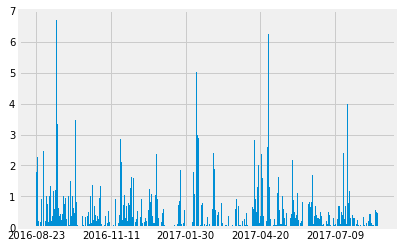

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
df = pd.read_sql(session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= past).statement, session.bind)\
    .set_index('date')\
        .dropna()\
            .sort_index()

fig, ax = plt.subplots()
# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(x = df.index, height=df['prcp'], width=1)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station).count()

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stat_count = func.count(Measurement.station)
station_activity = session.query(Measurement.station, stat_count).group_by(Measurement.station).order_by(stat_count.desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = station_activity[0][0]
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active).first()

(54.0, 85.0, 71.66378066378067)

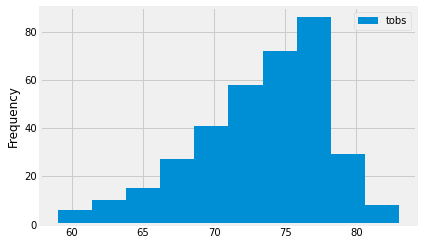

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_data = session.query(Measurement.tobs).filter(Measurement.station == most_active, Measurement.date >= past).all()
last_year_df = pd.DataFrame(last_year_data)
last_year_df.plot(kind='hist')

# Close session

In [16]:
# Close Session
session.close()